In [1]:
%%javascript
<!-- Ignore this block -->
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%config InlineBackend.figure_format = 'retina'

from __future__ import division
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import rankdata


"""Set global rcParams for pyplotlib"""
plt.rcParams["figure.figsize"] = "15, 150"

### TextEncoder

Here the data is mix of numbers and text. Text value cannot be directly used and should be converted to numeric data.<br>
For this I have created a function text encoder which accepts a pandas series. Text encoder returns a lookUp dictionary for recreating the numeric value for text value and encoded text vector.
For encoding I have applied a lambda function that will return value from dictionary.

In [3]:
""" Converts the text features into numeric values so that they can be used by 
the downstream algorithms. 
Accepts pandas series and returns lookup dictionary and encoded vector"""

def textEncoder(textVector):
    if type(textVector) == pd.core.series.Series:
        
        lookUpDictionary = {}
        lookupValue = 0
        for key in textVector.unique():
            lookUpDictionary[key] = lookupValue
            lookupValue +=1
        
        textVector = textVector.apply(lambda a: lookUpDictionary[a])
        return lookUpDictionary,textVector
            
        
    else:
        raise TypeError("Expected a pandas series as an input")   

### generatePearsonCoefficient Procedure
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec">
For sample:-
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0">
For selecting some features and for dropping others I am using Pearson's Coefficient. The value of Pearson's coefficient lies between [-1, 1] and tells how two features are related<br>
<table>
<tr><td>Strength of Association</td><td>Positive</td><td>Negative</td></tr><tr><td>Small</td><td>.1 to .3  </td><td>-0.1 to -0.3  </td></tr><tr><td>Medium</td><td>.3 to .5  </td><td>-0.3 to -0.5  </td></tr><tr><td>Large</td><td>.5 to 1.0 </td><td>-0.5 to -1.0  </td></tr></table>


In [4]:
"""Generate pearson's coefficient"""

def generatePearsonCoefficient(A, B):
    A = A - A.mean()
    B = B - B.mean()
    return ((A * B).sum())/(sqrt((A * A).sum()) * sqrt((B * B).sum())) 

## generateSpearmanCoefficient
https://en.m.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient

If the data is categorical we cannot use pearson's coeffecient as it assumes that data comes from normal distribution.<br>
However Spearman's coefficient is appropriate for both continuous and discrete ordinal variables.<br>

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a8dda555d22080d721679401fa13181cad3863f6"/>

This is same as pearson's coefficient applied to ranked values

In [5]:
def generateSpearmanCoefficient(x, y):
    
    """Rank the values"""
    n = len(x)
    xRanked = rankdata(x)
    yRanked = rankdata(y)
    
    """Generate Paerson's constant on ranked data"""
    return generatePearsonCoefficient(xRanked, yRanked)
    
    

## SplitDataSet Procedure
This method splits the dataset into trainset and testset based upon the trainSetSize value. For splitting the dataset, I am using pandas.sample to split the data. This gives me trainset. For testset I am calculating complement of the trainset. This I am doing by droping the index present in training set.

In [6]:
"""Splits the provided pandas dataframe into training and test dataset"""
def splitDataSet(inputDataframe, trainSetSize):
    
        trainSet = inputDataframe.sample(frac = trainSetSize)
        testSet = inputDataframe.drop(trainSet.index)
        return trainSet, testSet

## Logistic function
We are using sigmoid as a logistic function defined as <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9537e778e229470d85a68ee0b099c08298a1a3f6">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png">
This function calculates probabilities using sigmoid function


In [7]:
def logisticFunction(x):
    return 1.0/(1.0 + np.exp(-x))

## logLikelihood procedure

In [8]:
def logLikelihood(x, beta, y):
    betaX = np.dot(beta, x.T)
    return (np.dot(y, betaX) - np.log(1 + np.exp(betaX))).sum()

## Generate logLoss procedure
For binary classification
<img src="http://wiki.fast.ai/images/math/a/4/6/a4651d4ad311666c617d57c1dde37b28.png">

In [9]:
def logLoss(y, p):
    return -(y * np.log(p) + (1 - y) * np.log(1 - p)).sum()

## boldDriverStepLengthController procedure
This variant is for classifiation problems. 

In [10]:
def boldDriverStepLengthController(alpha, alphaPlus, alphaMinus, fNew, fOld):
    alpha = alpha * alphaPlus
    
    """If the function values are decreasing. Increase alpha"""
    if fNew < fOld:
        alpha = alphaPlus * alpha
    else:
        """If function value is increasing. Decrease alpha"""
        alpha = alphaMinus * alpha
    
    return alpha

## Adagrad procedure
Adaptive gradient descent steplength controller


In [11]:
"""Will provide seperate steplength controller for each beta """

def adagradController(initialStepLength, gradient, history = 0, epsilon = 1.0e-12):
    history = history + (gradient * gradient) + epsilon
    return (initialStepLength * 1.0)/np.sqrt(history), history

# Using gradient ascent
Here loglikelihood is being used making this problem of expectation maximization. The goal is to maximize the loglikelihood and hence gradient ascent is used. It should be noted that same can be done using gradient descent. In this case log loss will be used and objective will be to minimize the log loss. If logloss is used the gradient will be X<sup>T</sup>(P-Y) which is -ve of gradient for loglikelihood(X<sup>T</sup>(P-Y))

## Logistic regression (Gradient ascent)

In [12]:
def logisticRegression(x, y, xTest, yTest, beta, alpha, maxIterations = 1000, epsilon = 1.0e-12):
            
    """Add bias to x"""
    x = np.insert(x, 0, 1, axis = 1)
    xTest = np.insert(xTest, 0, 1, axis = 1)
    
    """Changing the data type to float"""
    x = x * 1.0
    y = y * 1.0
    xTest = xTest * 1.0
    yTest = yTest * 1.0
    
    xTranspose = x.T
    xTransposeTest = xTest.T
    
    betaX = np.dot(beta, xTranspose)
    
    """Calculating log likelihood"""
    logLikelihood = (y * betaX - np.log(1 + np.exp(betaX))).sum()
    
    """For plotting graphs"""
    iterationCount = []
    functionDifference = []
    logLossList = []
    logLikelihoodTrain = []
    logLikelihoodTest = []
    
    for i in range (0, maxIterations):
        
        """Calculate probability"""
        p = logisticFunction(betaX)
            
        """Here we are adding gradient as the we are trying to
        maximize the log likelihood and not minimize it"""
        gradient = np.dot(xTranspose, y - p)

        beta = beta + (alpha * gradient)
        
        betaX = np.dot(beta, xTranspose)
        logLikelihoodNew = (y * betaX - np.log(1 + np.exp(betaX))).sum()
        
        
        """For plotting graphs"""
        iterationCount.append(i)
        functionDifference.append(abs(logLikelihoodNew - logLikelihood))
        predictionTest = logisticFunction(np.dot(beta, xTransposeTest))
        logLossList.append(logLoss(yTest, predictionTest))
        logLikelihoodTrain.append(logLikelihoodNew)
        betaXTest = np.dot(beta, xTransposeTest)
        logLikelihoodTest.append((yTest * betaXTest - np.log(1 + np.exp(betaXTest))).sum())
        
        """Convergence condition"""
        if (abs(logLikelihoodNew - logLikelihood) < epsilon):
            return beta, iterationCount, functionDifference, logLossList, logLikelihoodTrain, logLikelihoodTest
    
        logLikelihood = logLikelihoodNew
        
    print("WARNING algorithm failed to converge")
    return beta, iterationCount, functionDifference, logLossList, logLikelihoodTrain, logLikelihoodTest

## stochasticGradientAscent
Instead of calculating the gradient for entire dataset, stochastic gradient descent/ascent will iterate over samples and update the gradient in each iteration. Stochastic gradient descent/ascent takes more iterations to converge however the time taken is less for large datasets when compared to gradient ascent/descent

In [13]:
def stochasticLogisticRegression(xTrain, yTrain, xTest, yTest, beta, alpha, 
                                 epochs = 4, epsilon = 1.0e-12, 
                                 stepLengthController = None, stepLengthControllerParameters = None):
    
    
    if stepLengthController != None:
        print("Warning using stepLengthController alpha values will be rewritten")

            
    """Add bias to x"""
    xTrain = np.insert(xTrain, 0, 1, axis = 1)
    xTest = np.insert(xTest, 0, 1, axis = 1)
    
    """Changing the data type to float"""
    xTrain = xTrain * 1.0
    yTrain = yTrain * 1.0
    xTest = xTest * 1.0
    yTest = yTest * 1.0
       
    """For plotting graphs"""
    iterationCount = []
    functionDifference = []
    logLossList = []
    logLikelihoodTrain = []
    logLikelihoodTest = []
    
    """Index"""
    indices = range(0, len(xTrain))

    """Calculating log likelihood"""
    logLikelihood = (yTrain * np.dot(beta, xTrain.T) - np.log(1 + np.exp(np.dot(beta, xTrain.T)))).sum()
    logLikelihoodNew = logLikelihood 
    
    history = 0
    for i in range (0, epochs):
        
        """Shuffle the indices"""                        
        np.random.shuffle(indices)
        
        for index in indices:    
            x = xTrain[index]
            y = yTrain[index]
        
            """Calculate probability"""
            betaX = np.dot(beta, x.T)
            p = logisticFunction(betaX)
            
            """Here we are adding gradient as the we are trying to
            maximize the log likelihood and not minimize it"""
            gradient = np.dot(x.T, y - p)
            
            
            """AdagradController is executed for each sample"""
            if stepLengthController == adagradController:
                alpha, history = stepLengthController(gradient = gradient, history = history, **stepLengthControllerParameters)

            beta = beta + (alpha * gradient)
        
            """For plotting graphs"""
        iterationCount.append(i)
        logLikelihoodTrain.append(logLikelihood)
        
        betaXTest = np.dot(beta, xTest.T)
        logLikelihoodTest.append((yTest * betaXTest - np.log(1 + np.exp(betaXTest))).sum())
        
        predictionTest = logisticFunction(np.dot(beta, xTest.T))
        logLossList.append(logLoss(yTest, predictionTest))
        
        """Calculating log likelihood"""
        logLikelihood = logLikelihoodNew
        logLikelihoodNew = (yTrain * np.dot(beta, xTrain.T) - np.log(1 + np.exp(np.dot(beta, xTrain.T)))).sum()
        functionDifference.append(abs(logLikelihoodNew - logLikelihood))
        
        """Bold driver is executed at end of epoch"""
        if stepLengthController == boldDriverStepLengthController:
                alpha = stepLengthController(fNew = logLikelihoodNew, alpha = alpha, fOld = logLikelihood, **stepLengthControllerParameters)
 
    return beta, iterationCount, functionDifference, logLossList, logLikelihoodTrain, logLikelihoodTest

### Prediction for gradient descent

In [14]:
def predictionBinaryClassifier(x, beta):
    """Add bias to x"""
    x = np.insert(x, 0, 1, axis = 1)
    probability = logisticFunction(np.dot(beta, x.T))
    func = np.vectorize(lambda x: 1 if x >=0.5 else 0)
    
    return probability

## Feature scaling
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/358923abc154221bb5022fc329061f6fc4dcc69f">

In [15]:
def scaleFeature(x):
    minX = min(x)
    maxX = max(x)
    return x.apply(lambda y: ((y * 1.0) - minX)/(maxX - minX))

### Load required data

In [16]:
""" File path change accordingly"""
directoryPath = "Data"


bankMarketingData = pd.read_csv(directoryPath+"/bank-additional.csv", sep=';')
bankMarketingData.head(10)


age           job   marital            education  default  housing  \
0   30   blue-collar   married             basic.9y       no      yes   
1   39      services    single          high.school       no       no   
2   25      services   married          high.school       no      yes   
3   38      services   married             basic.9y       no  unknown   
4   47        admin.   married    university.degree       no      yes   
5   32      services    single    university.degree       no       no   
6   32        admin.    single    university.degree       no      yes   
7   41  entrepreneur   married    university.degree  unknown      yes   
8   31      services  divorced  professional.course       no       no   
9   35   blue-collar   married             basic.9y  unknown       no   

      loan    contact month day_of_week ...  campaign  pdays  previous  \
0       no   cellular   may         fri ...         2    999         0   
1       no  telephone   may         fri ...         4    999         0   
2       no  telephone   jun         wed ...         1    999         0   
3  unknown  telephone   jun         fri ...         3    999         0   
4       no   cellular   nov         mon ...         1    999         0   
5       no   cellular   sep         thu ...         3    999         2   
6       no   cellular   sep         mon ...         4    999         0   
7       no   cellular   nov         mon ...         2    999         0   
8       no   cellular   nov         tue ...         1    999         1   
9       no  telephone   may         thu ...         1    999         0   

      poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent         -1.8          92.893          -46.2      1.313   
1  nonexistent          1.1          93.994          -36.4      4.855   
2  nonexistent          1.4          94.465          -41.8      4.962   
3  nonexistent          1.4          94.465          -41.8      4.959   
4  nonexistent         -0.1          93.200          -42.0      4.191   
5      failure         -1.1          94.199          -37.5      0.884   
6  nonexistent         -1.1          94.199          -37.5      0.879   
7  nonexistent         -0.1          93.200          -42.0      4.191   
8      failure         -0.1          93.200          -42.0      4.153   
9  nonexistent          1.1          93.994          -36.4      4.855   

   nr.employed   y  
0       5099.1  no  
1       5191.0  no  
2       5228.1  no  
3       5228.1  no  
4       5195.8  no  
5       4963.6  no  
6       4963.6  no  
7       5195.8  no  
8       5195.8  no  
9       5191.0  no  

[10 rows x 21 columns]

## Dataset Description
Source:https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
<ul>
<li>age (numeric)</li>
<li>job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")</li>
<li>marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)</li>
<li>education (categorical:"basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")</li>
<li>default: has credit in default? (categorical: "no","yes","unknown")</li>
<li>housing: has housing loan? (categorical: "no","yes","unknown")</li>
<li>loan: has personal loan? (categorical: "no","yes","unknown")</li>
<li>contact: contact communication type (categorical: "cellular","telephone")</li> 
<li>month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")</li>
<li>day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")</li>
<li>duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.</li>
<li>campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)</li>
<li>pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)</li>
<li>previous: number of contacts performed before this campaign and for this client (numeric)</li>
<li>poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")</li>
<li>emp.var.rate: employment variation rate - quarterly indicator (numeric)</li>
<li>cons.price.idx: consumer price index - monthly indicator (numeric)</li>
<li>cons.conf.idx: consumer confidence index - monthly indicator (numeric)</li>
<li>euribor3m: euribor 3 month rate - daily indicator (numeric)</li>
<li>nr.employed: number of employees - quarterly indicator (numeric)</li>
<li>y - has the client subscribed a term deposit? (binary: "yes","no")</li>

## Data preprocessing

### Drop NA values

In [17]:
print("Before removing NA data "+ str(bankMarketingData.shape))
bankMarketingData.dropna(inplace = True)
print("After removing NA data "+ str(bankMarketingData.shape))

Before removing NA data (4119, 21)
After removing NA data (4119, 21)


### Encoding y values and dropping the duration column. 
The reason for dropping this column is that we do not know the duration of call before hand

In [18]:
"""Encoding the outcome values using text encoder"""
yLookUpDictionary, bankMarketingData['y'] = textEncoder(bankMarketingData['y'])


"""Dropping duration as it will not be known beforehand while predicting"""
bankMarketingData = bankMarketingData.drop('duration', axis = 1)

### Scaling features
The features nr.employed, pdays, cons.price.idx and euribor3m will be scaled. The values now will be in range [0, 1]

In [19]:
bankMarketingData['nr.employed'] = scaleFeature(bankMarketingData['nr.employed'])
bankMarketingData['pdays'] = scaleFeature(bankMarketingData['pdays'])
bankMarketingData['cons.price.idx'] = scaleFeature(bankMarketingData['cons.price.idx'])
bankMarketingData['euribor3m'] = scaleFeature(bankMarketingData['euribor3m'])

bankMarketingData.head()

age          job  marital          education default  housing     loan  \
0   30  blue-collar  married           basic.9y      no      yes       no   
1   39     services   single        high.school      no       no       no   
2   25     services  married        high.school      no      yes       no   
3   38     services  married           basic.9y      no  unknown  unknown   
4   47       admin.  married  university.degree      no      yes       no   

     contact month day_of_week  campaign  pdays  previous     poutcome  \
0   cellular   may         fri         2    1.0         0  nonexistent   
1  telephone   may         fri         4    1.0         0  nonexistent   
2  telephone   jun         wed         1    1.0         0  nonexistent   
3  telephone   jun         fri         3    1.0         0  nonexistent   
4   cellular   nov         mon         1    1.0         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  y  
0          -1.8        0.269680          -46.2   0.153741     0.512287  0  
1           1.1        0.698753          -36.4   0.956916     0.859735  0  
2           1.4        0.882307          -41.8   0.981179     1.000000  0  
3           1.4        0.882307          -41.8   0.980499     1.000000  0  
4          -0.1        0.389322          -42.0   0.806349     0.877883  0

### Checking the relation between discrete features and y

In [20]:
""" Here we CANNOT USE Pearson's corelation constant. This is because the target values
are categorical. The pearson's constant makes an assumption that variables belong to normal distribution.
This is not true for categorical data. Instead we will use Spearman's corelation to check corelation
discrete variables and categorical values of y """


print("The Spearman's corelation constant between age and y is " + str(generateSpearmanCoefficient(bankMarketingData['age'], bankMarketingData['y'])))
print("The Spearman's corelation constant between campaign and y is " + str(generateSpearmanCoefficient(bankMarketingData['campaign'], bankMarketingData['y'])))
print("The Spearman's corelation constant between pdays and y is " + str(generateSpearmanCoefficient(bankMarketingData['pdays'], bankMarketingData['y'])))
print("The Spearman's corelation constant between previous and y is " + str(generateSpearmanCoefficient(bankMarketingData['previous'], bankMarketingData['y'])))
print("The Spearman's corelation constant between emp.var.rate and y is " + str(generateSpearmanCoefficient(bankMarketingData['emp.var.rate'], bankMarketingData['y'])))
print("The Spearman's corelation constant between cons.price.idx and y is " + str(generateSpearmanCoefficient(bankMarketingData['cons.price.idx'], bankMarketingData['y'])))
print("The Spearman's corelation constant between cons.conf.idx and y is " + str(generateSpearmanCoefficient(bankMarketingData['cons.conf.idx'], bankMarketingData['y'])))
print("The Spearman's corelation constant between euribor3m and y is " + str(generateSpearmanCoefficient(bankMarketingData['euribor3m'], bankMarketingData['y'])))
print("The Spearman's corelation constant between nr.employed and y is " + str(generateSpearmanCoefficient(bankMarketingData['nr.employed'], bankMarketingData['y'])))

The Spearman's corelation constant between age and y is 0.0228828622675
The Spearman's corelation constant between campaign and y is -0.0609463850829
The Spearman's corelation constant between pdays and y is -0.332285936854
The Spearman's corelation constant between previous and y is 0.216073655789
The Spearman's corelation constant between emp.var.rate and y is -0.23250040029
The Spearman's corelation constant between cons.price.idx and y is -0.0852904360327
The Spearman's corelation constant between cons.conf.idx and y is 0.0468097379008
The Spearman's corelation constant between euribor3m and y is -0.266042053852
The Spearman's corelation constant between nr.employed and y is -0.276380053457


We can drop age, campaign, cons.conf.idx, cons.price.idx as the corelation appears to be very small

### Checking the relation between  categorical features and y using stacked bar charts

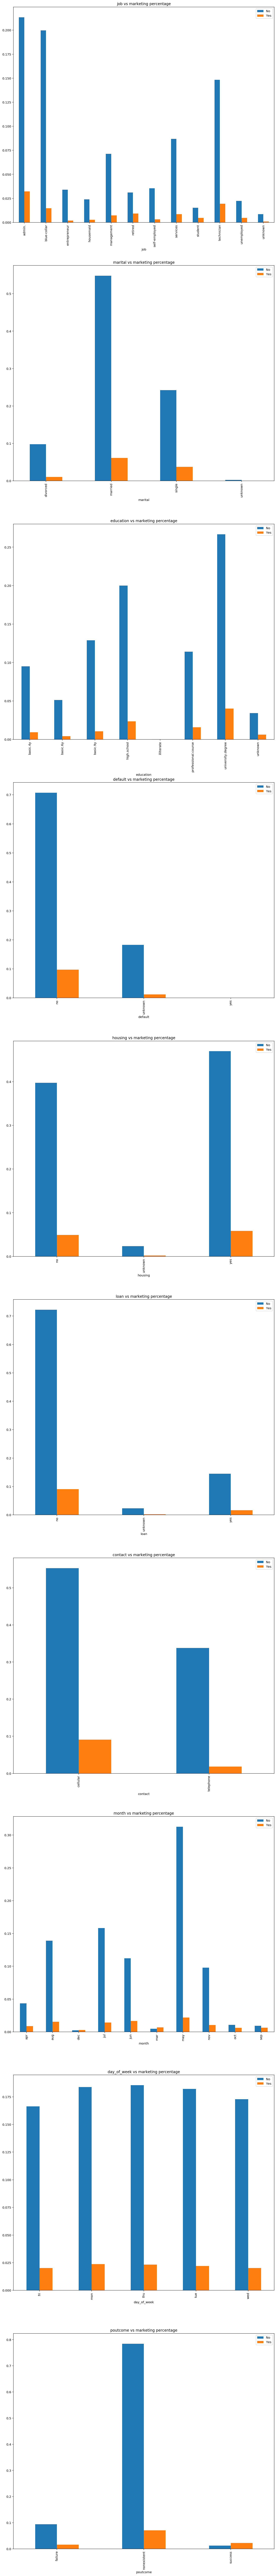

In [21]:
fig, axs = plt.subplots(10,1)
axs = axs.flatten()
index = 0
categoricalfeatures = ['job', 'marital', 'education', 'default', 
                       'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for feature in categoricalfeatures:
    
    (bankMarketingData.groupby([feature, 'y']).size()/len(bankMarketingData)).unstack().plot(kind = 'bar', 
                                                                                             stacked = False, ax = axs[index], title = feature + " vs marketing percentage")
    axs[index].legend(['No', 'Yes'])
    index = index + 1
        
plt.show()
plt.close()

From the above charts we can say outcome y has little to no dependency on day_of_week and housing. This can be deduced based upon spread of different categories. If the variance is very less we can drop those attributes.

### Dropping trivial or less important features

In [22]:
"""Based upon the values from Spearman's corelation constant and graphs above we can drop some columns(features)"""
bankMarketingData = bankMarketingData.drop(['day_of_week', 'housing', 'age', 'campaign', 'cons.conf.idx','cons.price.idx'], axis = 1)
bankMarketingData.head()

job  marital          education default     loan    contact month  \
0  blue-collar  married           basic.9y      no       no   cellular   may   
1     services   single        high.school      no       no  telephone   may   
2     services  married        high.school      no       no  telephone   jun   
3     services  married           basic.9y      no  unknown  telephone   jun   
4       admin.  married  university.degree      no       no   cellular   nov   

   pdays  previous     poutcome  emp.var.rate  euribor3m  nr.employed  y  
0    1.0         0  nonexistent          -1.8   0.153741     0.512287  0  
1    1.0         0  nonexistent           1.1   0.956916     0.859735  0  
2    1.0         0  nonexistent           1.4   0.981179     1.000000  0  
3    1.0         0  nonexistent           1.4   0.980499     1.000000  0  
4    1.0         0  nonexistent          -0.1   0.806349     0.877883  0

### Converting categorical data to one hot encoding
One hot encoding will not add any additional bias.

In [23]:
bankMarketingData = pd.get_dummies(bankMarketingData)
bankMarketingData.head()

pdays  previous  emp.var.rate  euribor3m  nr.employed  y  job_admin.  \
0    1.0         0          -1.8   0.153741     0.512287  0           0   
1    1.0         0           1.1   0.956916     0.859735  0           0   
2    1.0         0           1.4   0.981179     1.000000  0           0   
3    1.0         0           1.4   0.980499     1.000000  0           0   
4    1.0         0          -0.1   0.806349     0.877883  0           1   

   job_blue-collar  job_entrepreneur  job_housemaid        ...         \
0                1                 0              0        ...          
1                0                 0              0        ...          
2                0                 0              0        ...          
3                0                 0              0        ...          
4                0                 0              0        ...          

   month_jul  month_jun  month_mar  month_may  month_nov  month_oct  \
0          0          0          0          1          0          0   
1          0          0          0          1          0          0   
2          0          1          0          0          0          0   
3          0          1          0          0          0          0   
4          0          0          0          0          1          0   

   month_sep  poutcome_failure  poutcome_nonexistent  poutcome_success  
0          0                 0                     1                 0  
1          0                 0                     1                 0  
2          0                 0                     1                 0  
3          0                 0                     1                 0  
4          0                 0                     1                 0  

[5 rows x 51 columns]

### Split dataset

In [24]:
xTrain, xTest = splitDataSet(bankMarketingData, 0.8)

"""Removing X and Y components"""
yTrain = xTrain['y']
xTrain = xTrain.drop('y', axis = 1)

yTest = xTest['y']
xTest = xTest.drop('y', axis = 1)


print("Training data size " + str(len(xTrain)))
print("Training data size "+ str(len(xTest)))

Training data size 3295
Training data size 824


### Executing logistic regression

In [25]:
beta, xAxis, functionDifference, logLossTest, logLikelihoodTrain, logLikelihoodTest = logisticRegression(xTrain.as_matrix(), yTrain.as_matrix(),
                                                     xTest.as_matrix(), yTest.as_matrix(), 
                                                     np.zeros(xTrain.shape[1] + 1) , 1e-5)

WARNING algorithm failed to converge


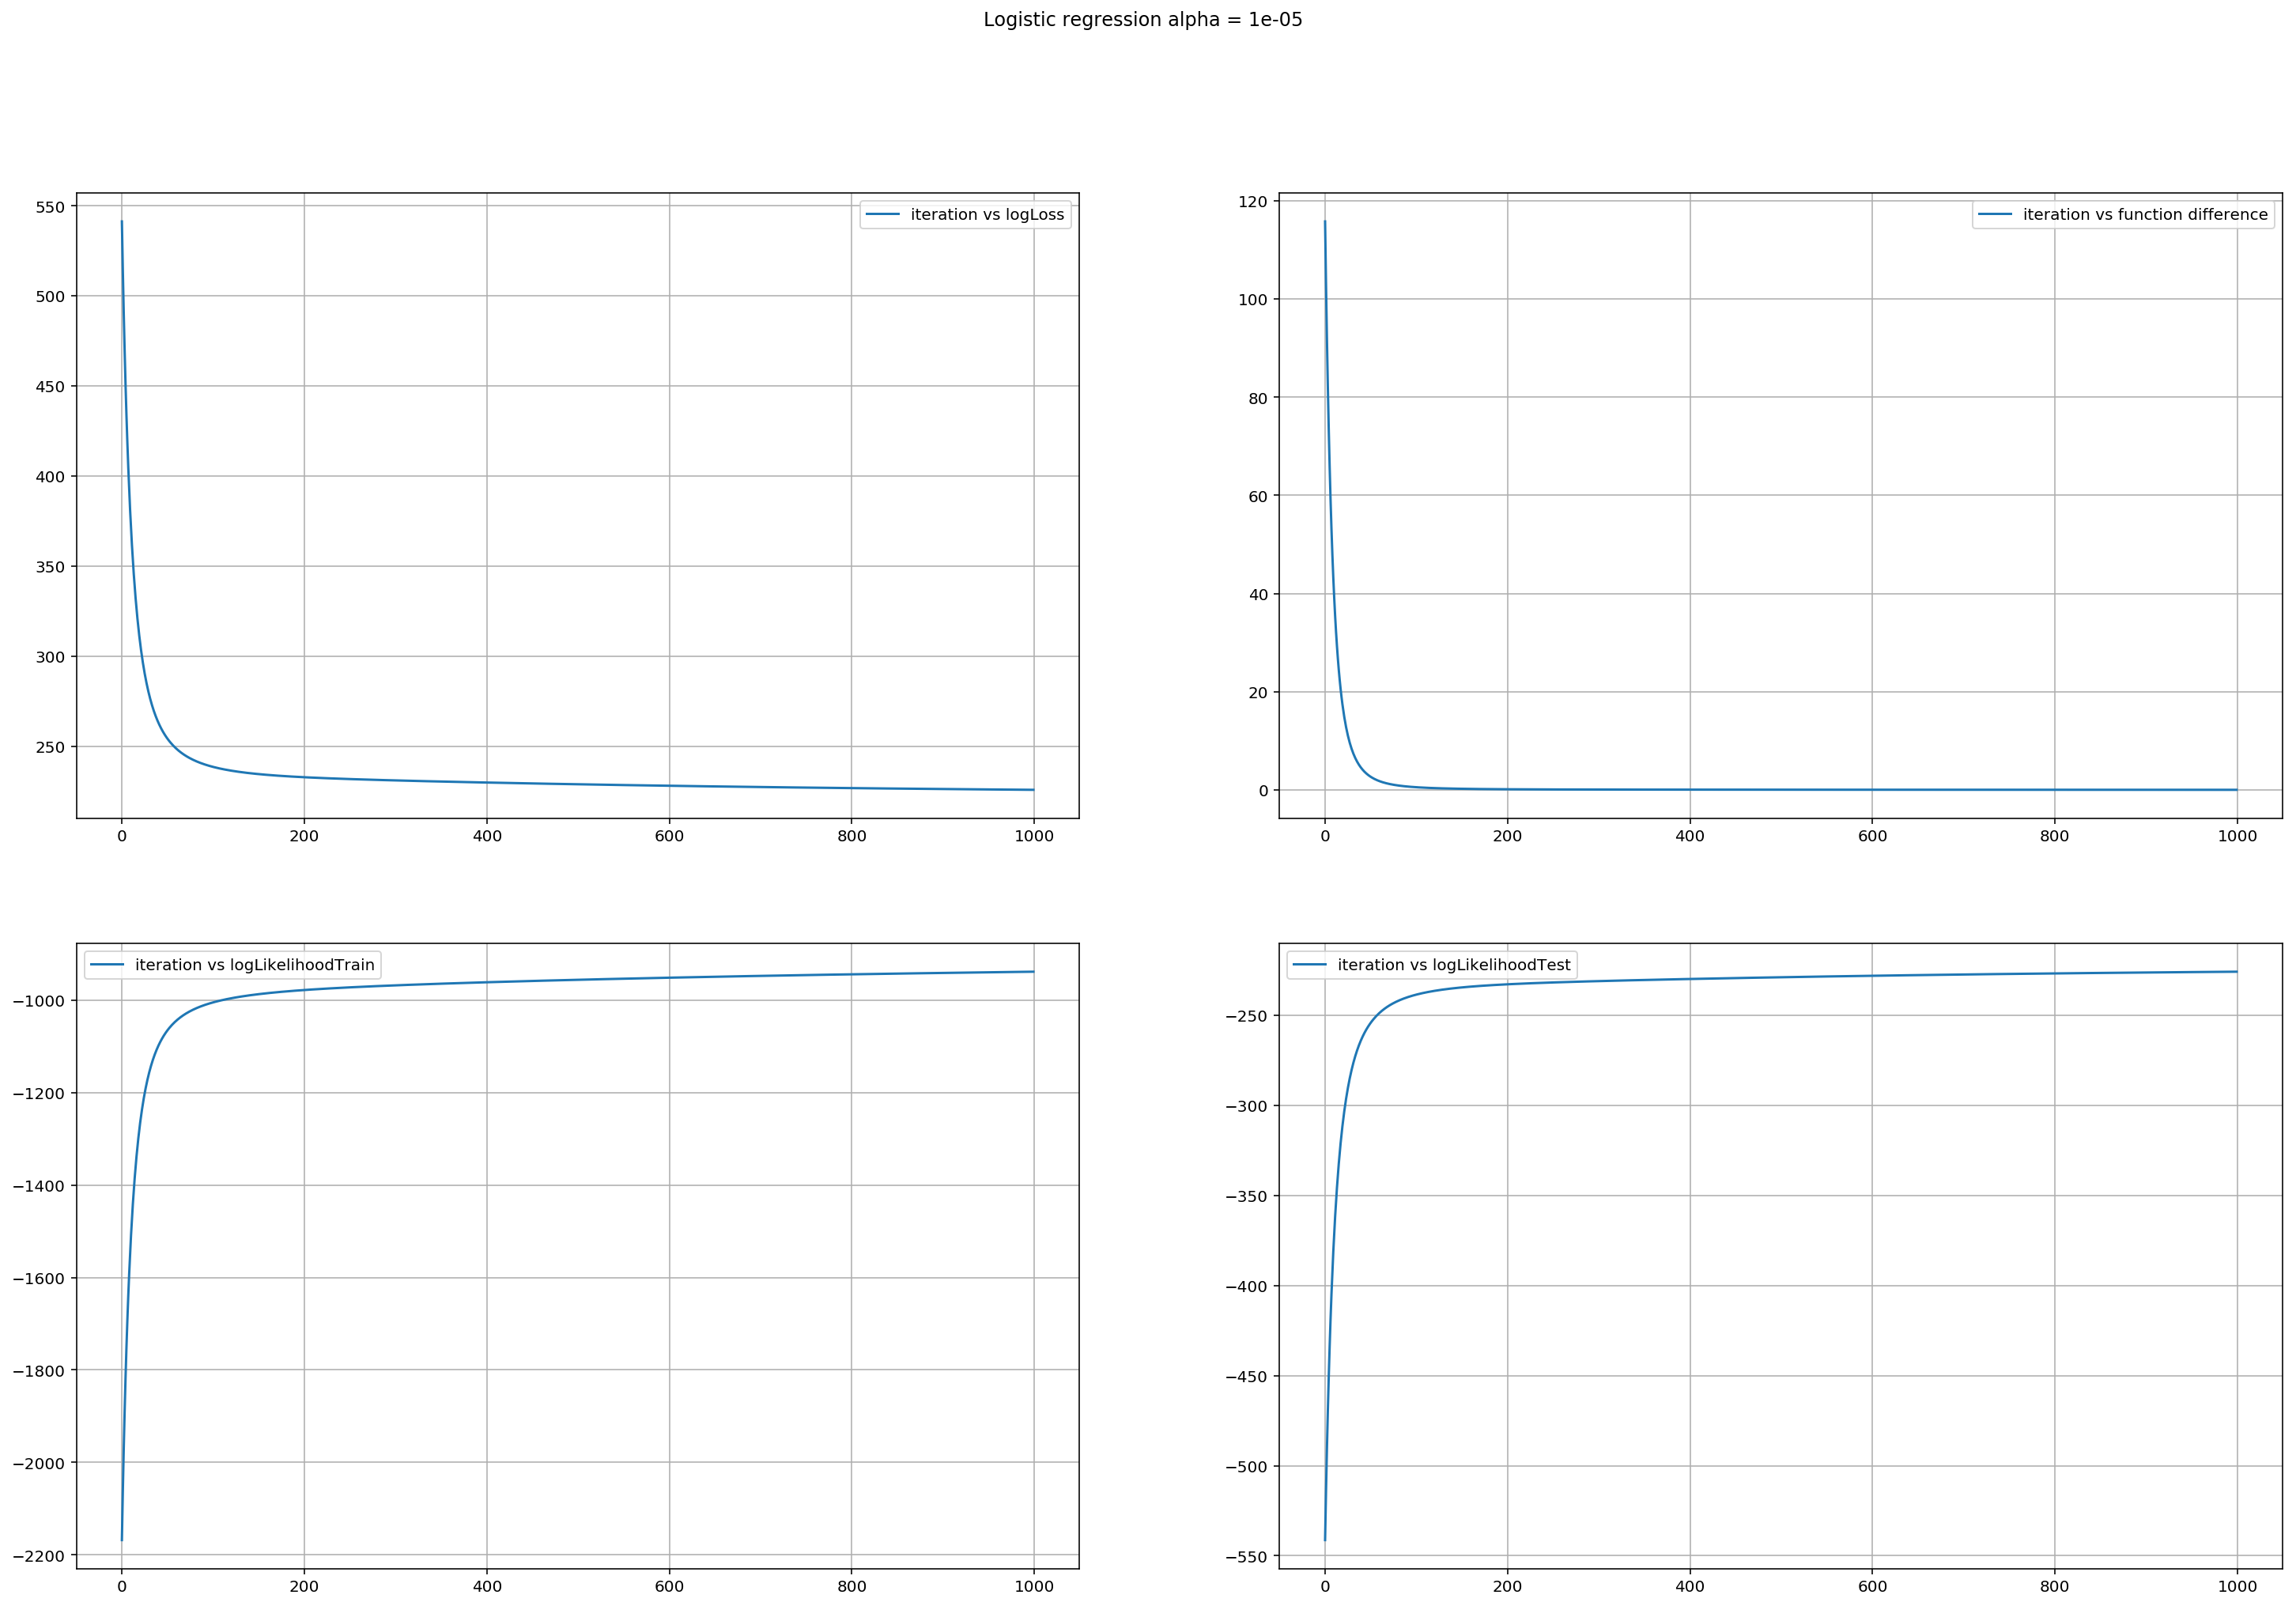

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(25, 16))
plt.suptitle("Logistic regression alpha = " + str(1e-5))
axs[0][0].plot(xAxis, logLossTest, label = "iteration vs logLoss")
axs[0][0].grid()
axs[0][0].legend()


axs[0][1].plot(xAxis, functionDifference, label = "iteration vs function difference")
axs[0][1].grid()
axs[0][1].legend()


axs[1][0].plot(xAxis, logLikelihoodTrain, label = "iteration vs logLikelihoodTrain")
axs[1][0].grid()
axs[1][0].legend()


axs[1][1].plot(xAxis, logLikelihoodTest, label = "iteration vs logLikelihoodTest")
axs[1][1].grid()
axs[1][1].legend()



plt.show()

Here we can see that logloss is decreasing. Furthermore the logloss = -logLikelihood for testset<br>
For both the train set and test set the loglikelihood is increasing hence gradient ascent is working for the provided set.

### Executing stochastic Logistic Regression

In [27]:
"""Here alpha = 5.5e-5 gives better results but it is 
very smooth. For explaining purpose alpha has been increased"""

beta, xAxis, functionDifference, logLossTest, logLikelihoodTrain, logLikelihoodTest = stochasticLogisticRegression(xTrain.as_matrix(), 
                                                                                                                   yTrain.as_matrix(), xTest.as_matrix(), 
                                                                                                                   yTest.as_matrix(), 
                                                                                                                   np.zeros(xTrain.shape[1] + 1), 5.5e-4, 200)

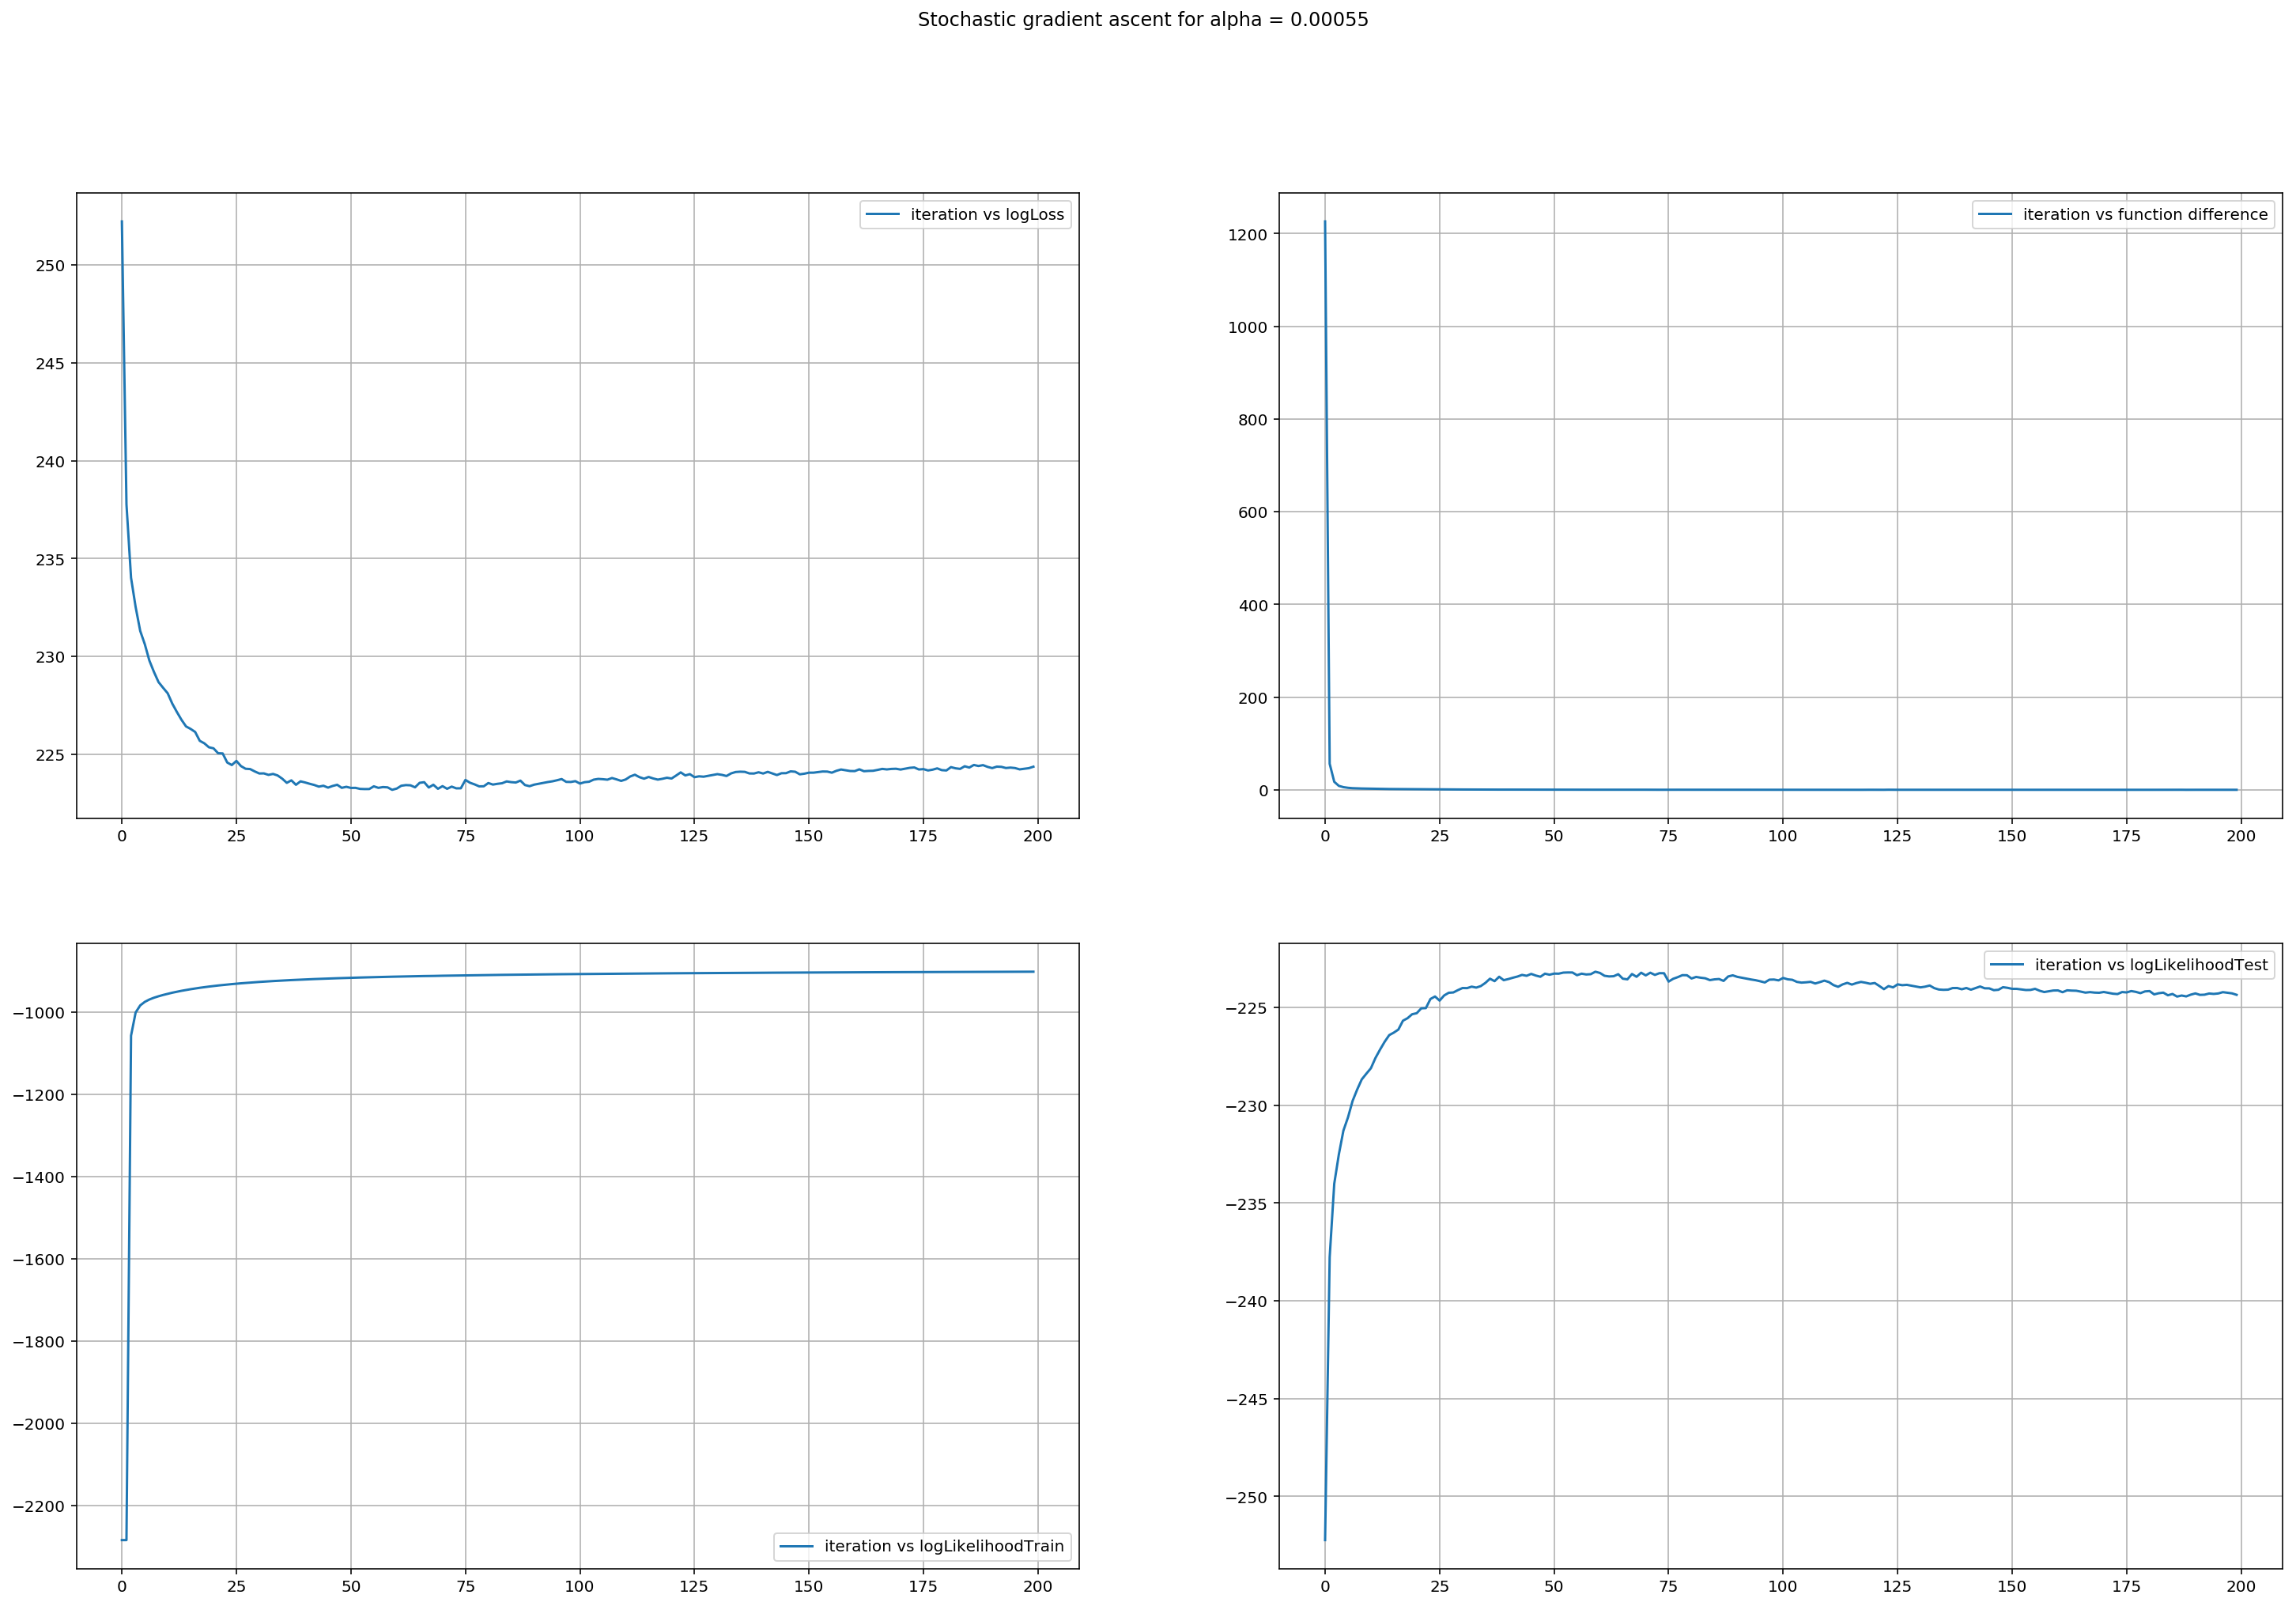

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(25, 16))
plt.suptitle("Stochastic gradient ascent for alpha = " + str(5.5e-4))

axs[0][0].plot(xAxis, logLossTest, label = "iteration vs logLoss")
axs[0][0].grid()
axs[0][0].legend()


axs[0][1].plot(xAxis, functionDifference, label = "iteration vs function difference")
axs[0][1].grid()
axs[0][1].legend()


axs[1][0].plot(xAxis, logLikelihoodTrain, label = "iteration vs logLikelihoodTrain")
axs[1][0].grid()
axs[1][0].legend()


axs[1][1].plot(xAxis, logLikelihoodTest, label = "iteration vs logLikelihoodTest")
axs[1][1].grid()
axs[1][1].legend()


plt.show()

Here we can see that graph is little zigzag. This is because of stochastic gradient ascent. Loglikelihood for both training and testset are increasing. Which means that gradient ascent is working. Also loglikelihood = -logloss for testset. 

### Stochastic Logistic regression with bold driver step length controller

In [29]:
beta, xAxis, functionDifference, logLossTest, logLikelihoodTrain, logLikelihoodTest = stochasticLogisticRegression(xTrain.as_matrix(), 
                                                                                                                   yTrain.as_matrix(), xTest.as_matrix(), 
                                                                                                                   yTest.as_matrix(), 
                                                                                                                   np.zeros(xTrain.shape[1] + 1), 1e-5, 1000,
                                                                                                                   stepLengthController = boldDriverStepLengthController,
                                                                                                                   stepLengthControllerParameters = {"alphaMinus" : 0.999, "alphaPlus" : 1.001})

Warning using stepLengthController alpha values will be rewritten


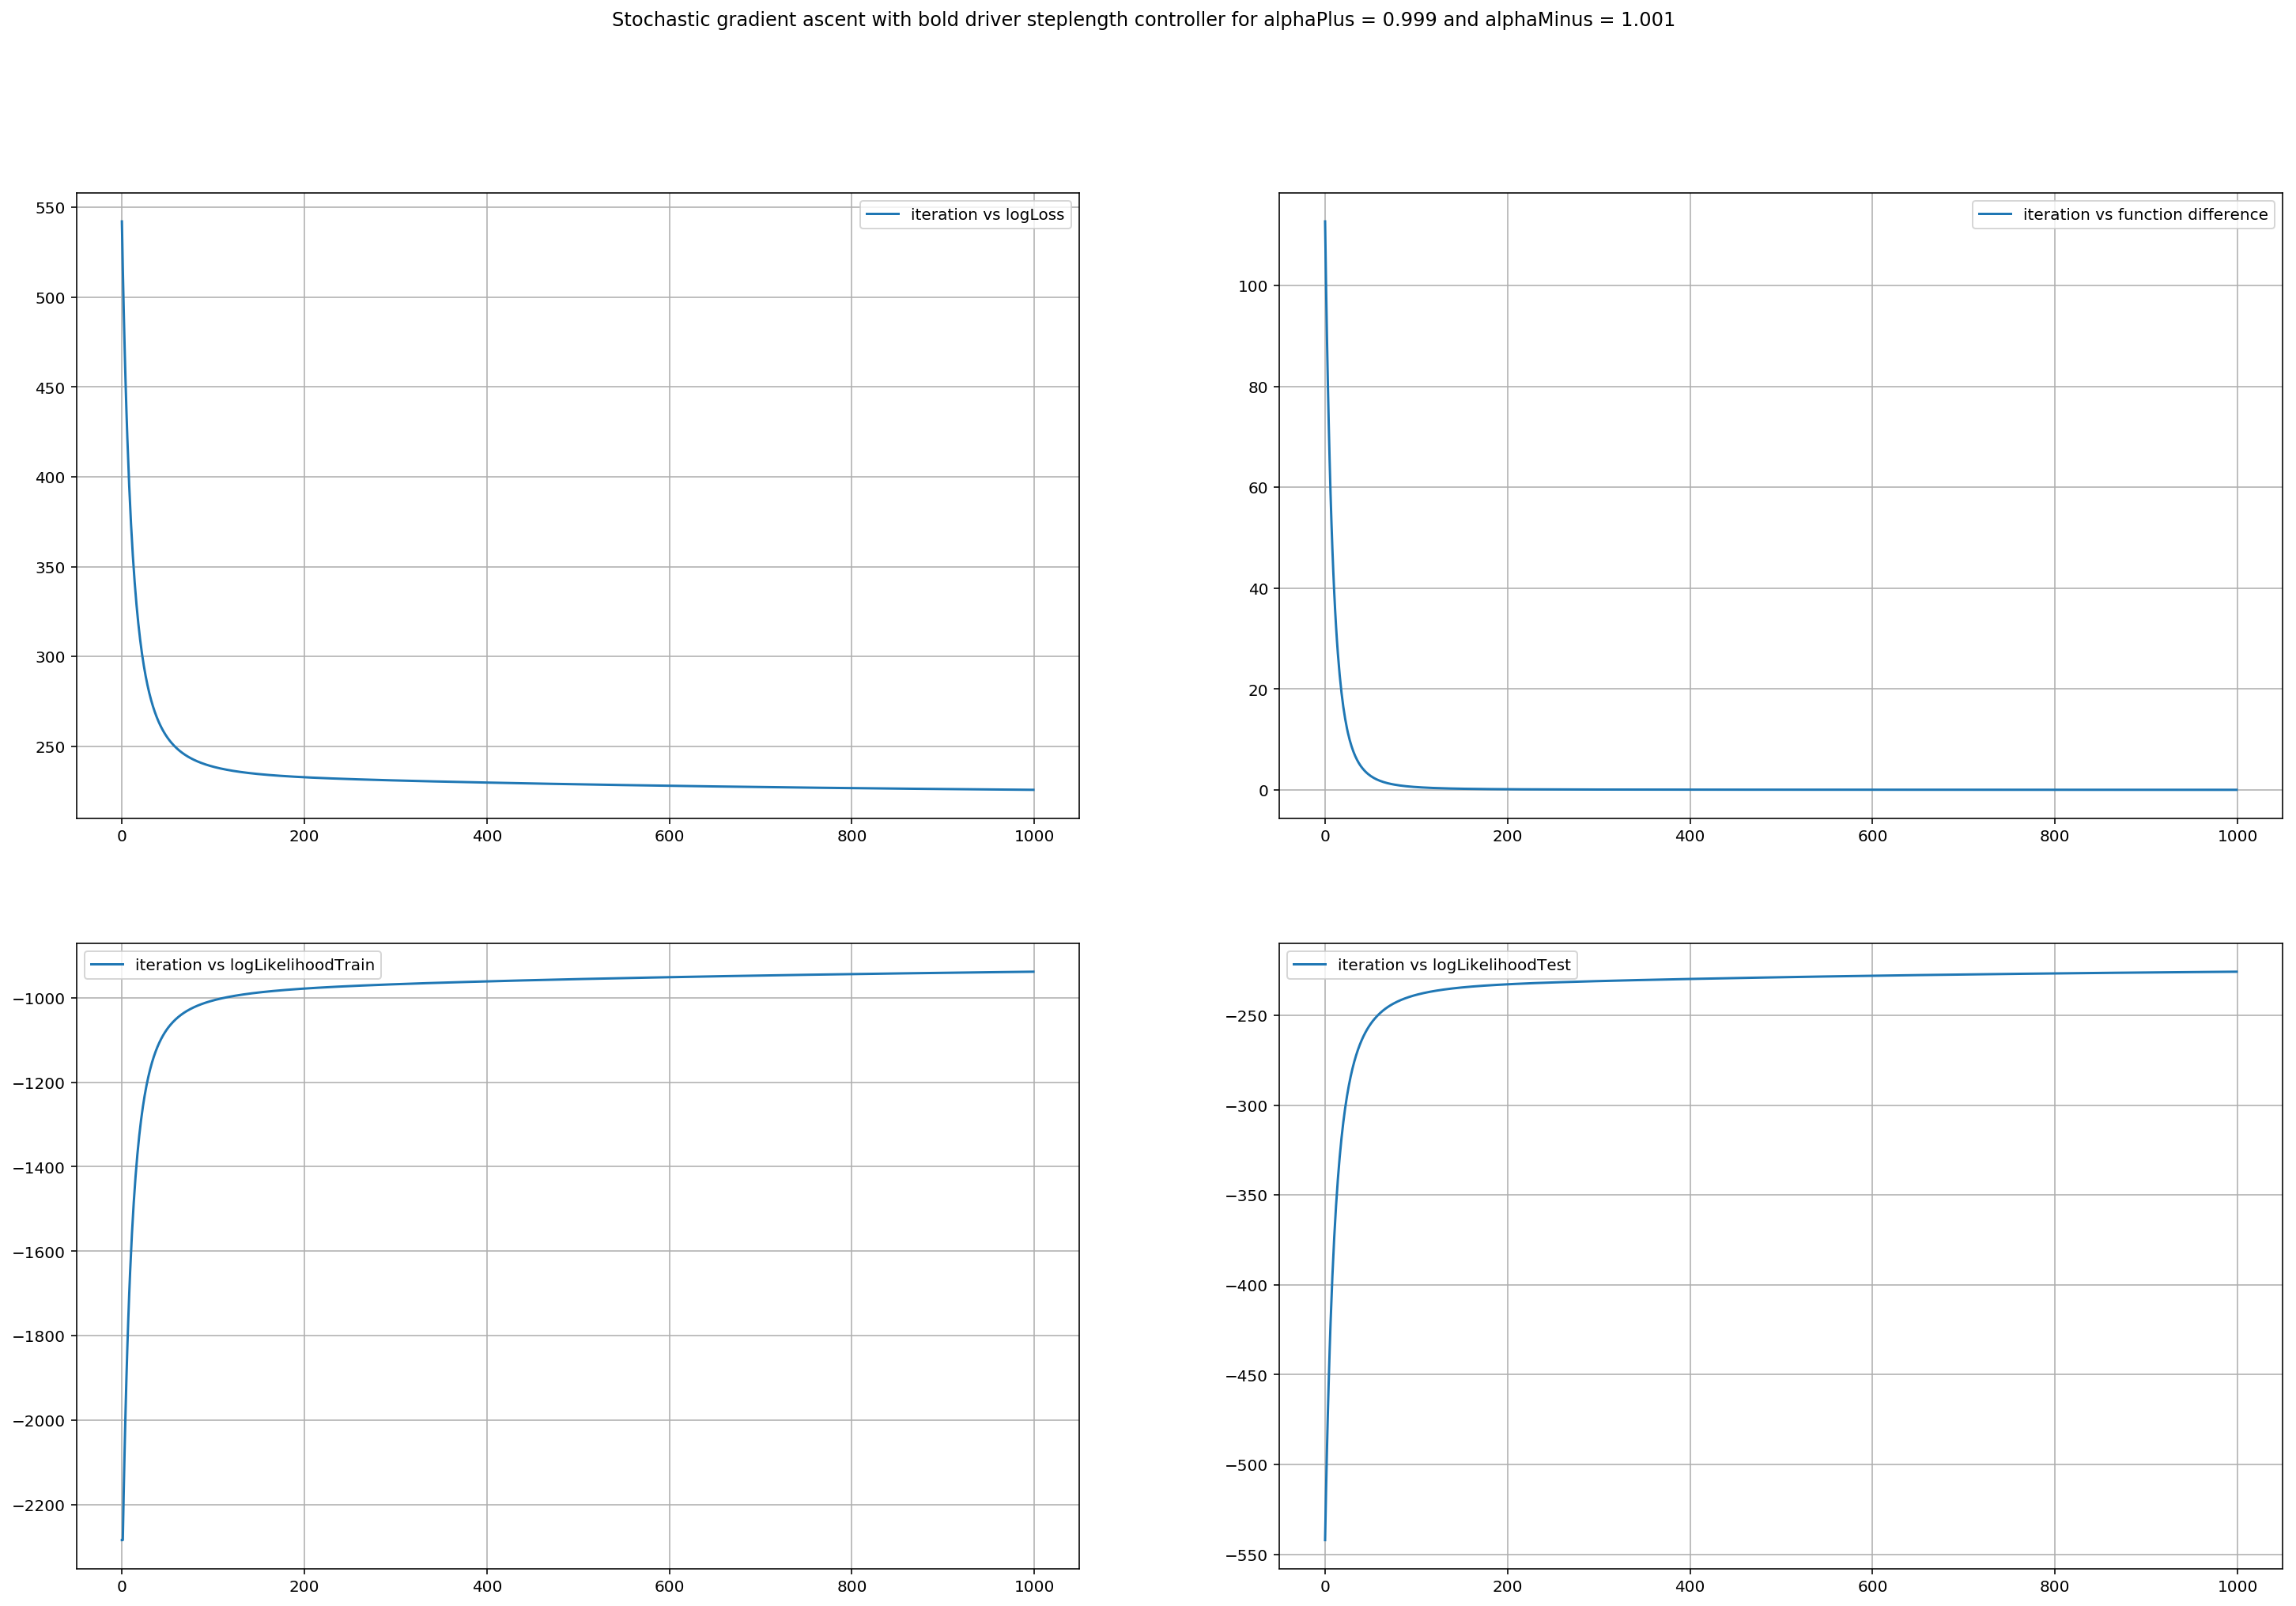

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(25, 16))
plt.suptitle("Stochastic gradient ascent with bold driver steplength controller for alphaPlus = " + str(0.999) +
                    " and alphaMinus = " + str(1.001))

axs[0][0].plot(xAxis, logLossTest, label = "iteration vs logLoss")
axs[0][0].grid()
axs[0][0].legend()

axs[0][1].plot(xAxis, functionDifference, label = "iteration vs function difference")
axs[0][1].grid()
axs[0][1].legend()


axs[1][0].plot(xAxis, logLikelihoodTrain, label = "iteration vs logLikelihoodTrain")
axs[1][0].grid()
axs[1][0].legend()


axs[1][1].plot(xAxis, logLikelihoodTest, label = "iteration vs logLikelihoodTest")
axs[1][1].grid()
axs[1][1].legend()


plt.show()

### Stochastic Logistic regression with adagrad step length controller

In [31]:
beta, xAxis, functionDifference, logLossTest, logLikelihoodTrain, logLikelihoodTest = stochasticLogisticRegression(xTrain.as_matrix(), 
                                                                                                                   yTrain.as_matrix(), xTest.as_matrix(), 
                                                                                                                   yTest.as_matrix(), 
                                                                                                                   np.zeros(xTrain.shape[1] + 1), 1e-5, 250,
                                                                                                                   stepLengthController = adagradController,
                                                                                                                   stepLengthControllerParameters = {"initialStepLength":0.1e-2})

Warning using stepLengthController alpha values will be rewritten


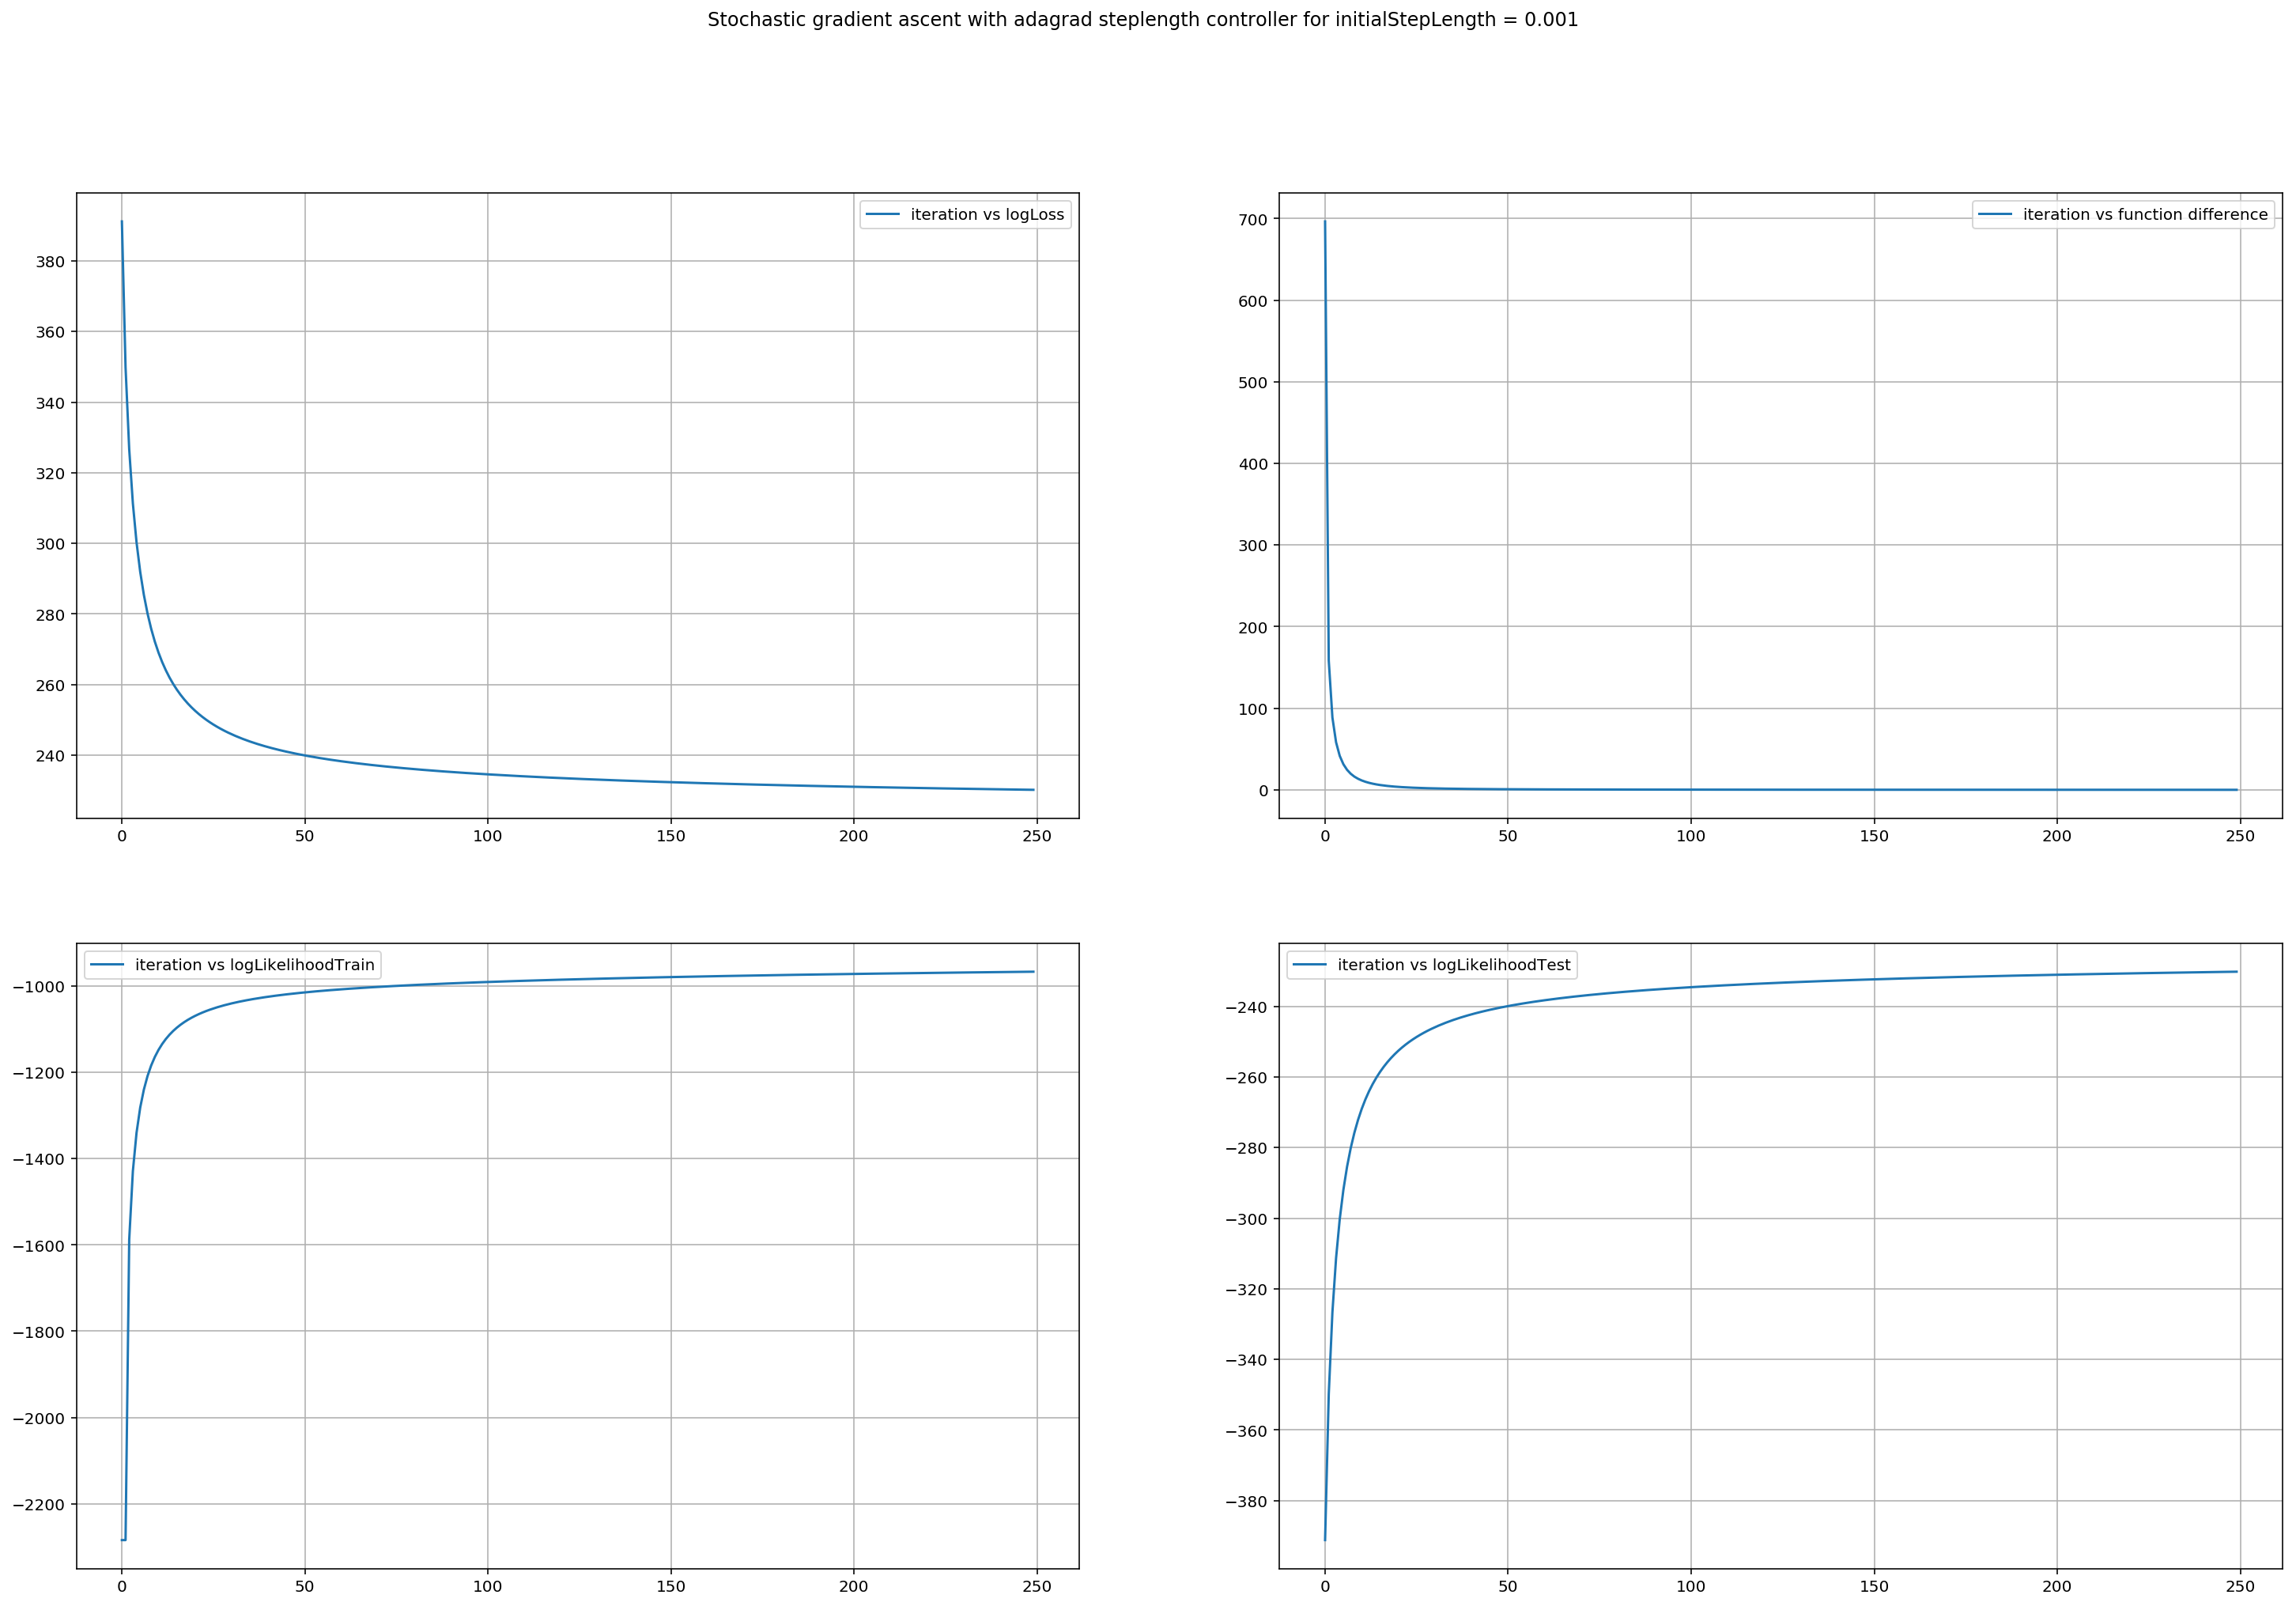

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(25, 16))
plt.suptitle("Stochastic gradient ascent with adagrad steplength controller for initialStepLength = " + str(0.1e-2))

axs[0][0].plot(xAxis, logLossTest, label = "iteration vs logLoss")
axs[0][0].grid()
axs[0][0].legend()


axs[0][1].plot(xAxis, functionDifference, label = "iteration vs function difference")
axs[0][1].grid()
axs[0][1].legend()

axs[1][0].plot(xAxis, logLikelihoodTrain, label = "iteration vs logLikelihoodTrain")
axs[1][0].grid()
axs[1][0].legend()

axs[1][1].plot(xAxis, logLikelihoodTest, label = "iteration vs logLikelihoodTest")
axs[1][1].grid()
axs[1][1].legend()


plt.show()